# Classification

Notebook autour d'un cas de classification binaire.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Les données

In [3]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

In [4]:
X, y = data.data, data.target

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [6]:
X.shape

(569, 30)

## ACP

On projette les données dans un plan, avec une couleur pour chaque classe pour voir si le problème paraît simple ou non. Pour projeter les données, le plus simple est une ACP. On conserver trois axes.

In [7]:
from sklearn.decomposition import PCA
acp = PCA(3)
acp.fit(X_train, y_train)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [8]:
xacp = acp.transform(X_train)
xacp.shape

(426, 3)

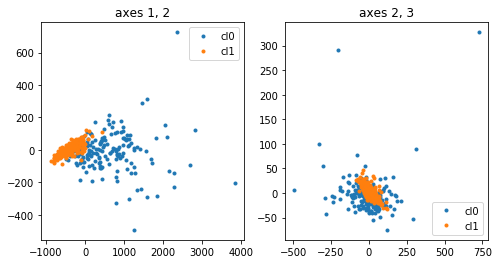

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(xacp[y_train == 0, 0], xacp[y_train == 0, 1], '.', label="cl0")
ax[0].plot(xacp[y_train == 1, 0], xacp[y_train == 1, 1], '.', label="cl1")
ax[1].plot(xacp[y_train == 0, 1], xacp[y_train == 0, 2], '.', label="cl0")
ax[1].plot(xacp[y_train == 1, 1], xacp[y_train == 1, 2], '.', label="cl1")
ax[0].legend();ax[1].legend();
ax[0].set_title("axes 1, 2");ax[1].set_title("axes 2, 3");

Le problème n'a pas l'air trop compliqué.

## Régression logistique

In [10]:
from sklearn.linear_model import LogisticRegression

In [11]:
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(xacp, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Les coefficients. Si $(X_1, X_2, X_3)$ sont les coordonnées des variables projetées sur les trois axes, le modèle définit une droite $f(x_1, x_2, x_3) = a_1 x_1 + a_2 x_2 + a_3 x_3 + b$.

In [12]:
logreg.coef_, logreg.intercept_

(array([[-0.01244239,  0.02897613, -0.0194635 ]]), array([-1.48191575]))

La courbe $f(x_1, x_2, x_3) = 0$ définit la frontière entre les deux classes, celle où la probabilité d'appartenir à l'une ou l'autre classe est égale à $\frac{1}{2}$. On ajoute cette frontière sur chacune des deux projections. $f(x_1, x_2, x_3) = a_1 x_1 + a_2 x_2 + a_3 x_3 + b = 0$. Sur la première projection, $x_3 = 0$, donc la droite a pour équation : $ a_1 x_1 + a_2 x_2 + a_3 x_3 + b = 0 \Rightarrow x_2 = - \frac{ a_1 x_1 + b}{a_2}$. C'est ce qu'on représente ici.

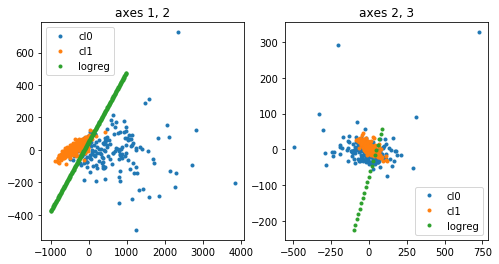

In [13]:
import numpy
X1 = numpy.array(list(range(-1000, 1000, 10)))
X2 = (-logreg.intercept_[0]-logreg.coef_[0, 0]*X1) / logreg.coef_[0, 1]
X22 = numpy.array(list(range(-100, 100, 10)))
X3 = (-logreg.intercept_[0]-logreg.coef_[0, 1]*X22) / logreg.coef_[0, 2]

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(xacp[y_train == 0, 0], xacp[y_train == 0, 1], '.', label="cl0")
ax[0].plot(xacp[y_train == 1, 0], xacp[y_train == 1, 1], '.', label="cl1")
ax[0].plot(X1, X2, '.', label="logreg")
ax[1].plot(xacp[y_train == 0, 1], xacp[y_train == 0, 2], '.', label="cl0")
ax[1].plot(xacp[y_train == 1, 1], xacp[y_train == 1, 2], '.', label="cl1")
ax[1].plot(X22, X3, '.', label="logreg")
ax[0].legend();ax[1].legend();
ax[0].set_title("axes 1, 2");ax[1].set_title("axes 2, 3");

On calcule la matrice de confusion. Il faut projeter les variables initiales sur les axes de l'ACP puis prédire.

In [14]:
xacp_test = acp.transform(X_test)
pred = logreg.predict(xacp_test)

In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred)

array([[42,  4],
       [ 4, 93]], dtype=int64)

## Courbe ROC

La courbe ROC est une courbe souvent utilisée pour mesurer la pertinence d'un modèle. La matrice de confusion n'utilise pas la probabilité retournée par le modèle, cette dernière exprime si le point $X_i$ est plus ou moins loin de la frontière de prédiction. En principe, plus on est loin, moins le modèle prédictif se trompe. C'est ce que la courbe ROC reflète, plus elle est élevé, plus c'est le cas (pour en savoir plus : [courbe ROC](http://www.xavierdupre.fr/app/mlstatpy/helpsphinx/c_metric/roc.html)).

In [16]:
from sklearn.metrics import roc_curve

y_pred_grd = logreg.predict_proba(xacp_test)[:, 1]
fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_grd)

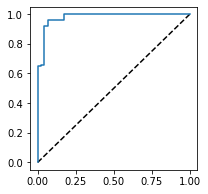

In [17]:
plt.figure(1, figsize=(3, 3))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_grd, tpr_grd);

La ligne en pointillée serait la courbe ROC obtenue pour une prédiction aléatoire. On en est loin.

## Frontière polynômiale

On souhaite une frontière polynômiale. On ajoute pour cela un prétraitement qui calcule $X_1^2, X_2^2, X_3^2, X_1 X_2, ...$.

In [18]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)
poly.fit(xacp)

PolynomialFeatures(degree=2, include_bias=True, interaction_only=False,
                   order='C')

In [19]:
xacp_poly = poly.transform(xacp)
xacp.shape, xacp_poly.shape

((426, 3), (426, 10))

In [20]:
logreg2 = LogisticRegression(solver='lbfgs', max_iter=1000)
logreg2.fit(xacp_poly, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Les nouveaux coefficients du modèle.

In [21]:
list(zip(poly.get_feature_names(), logreg2.coef_.ravel()))

[('1', 0.00013474687830331624),
 ('x0', -0.009796886245028377),
 ('x1', 0.03422545572030919),
 ('x2', -0.005487261266497426),
 ('x0^2', 6.912136603531012e-07),
 ('x0 x1', -4.353833813532155e-05),
 ('x0 x2', -0.00019255718749305347),
 ('x1^2', -0.0004269054807770011),
 ('x1 x2', -0.0018760934646931198),
 ('x2^2', -0.0042992267040219976)]

La frontière est plus difficile à tracer et il n'est pas évident de trouver son équation à moins de résoudre un polynôme du second degré. On calcule plutôt les prédictions pour de nombreux points disposés sur une grille en leur donnant une couleur différente selon que la classe prédite est 0 ou 1.

In [22]:
Xp1 = numpy.array(list(range(-1000, 1000, 10)))
Xp2 = numpy.array(list(range(-100, 100, 2)))
cote0 = []
cote1 = []
for x1 in Xp1:
    for x2 in Xp2:
        x = numpy.array([[x1, x2, 0]])
        xp = poly.transform(x)
        yp = logreg2.predict(xp)
        if yp == 1:
            cote1.append((x1, x2))
        else:
            cote0.append((x1, x2))

cote0 = numpy.array(cote0)
cote1 = numpy.array(cote1)

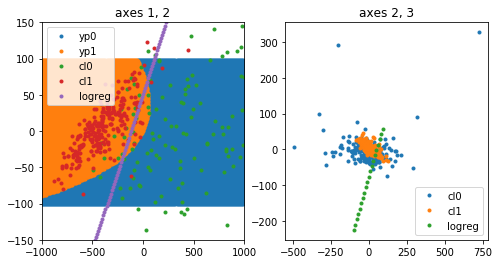

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(cote0[:, 0], cote0[:, 1], '.', label='yp0')
ax[0].plot(cote1[:, 0], cote1[:, 1], '.', label='yp1')
ax[0].plot(xacp[y_train == 0, 0], xacp[y_train == 0, 1], '.', label="cl0")
ax[0].plot(xacp[y_train == 1, 0], xacp[y_train == 1, 1], '.', label="cl1")
ax[0].plot(X1, X2, '.', label="logreg")
ax[1].plot(xacp[y_train == 0, 1], xacp[y_train == 0, 2], '.', label="cl0")
ax[1].plot(xacp[y_train == 1, 1], xacp[y_train == 1, 2], '.', label="cl1")
ax[1].plot(X22, X3, '.', label="logreg")
ax[0].legend();ax[1].legend();
ax[0].set_xlim([-1000, 1000]);ax[0].set_ylim([-150, 150]);
ax[0].set_title("axes 1, 2");ax[1].set_title("axes 2, 3");

Ca paraît un peu mieux.

In [24]:
confusion_matrix(y_test, 
                 logreg2.predict(
                     poly.transform(
                         acp.transform(X_test))))

array([[41,  5],
       [ 4, 93]], dtype=int64)

## Pipeline

Ce n'est pas évident de se souvenir de toutes les étapes. Le mieux est sans doute de tout insérer dans un pipeline.

In [25]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([
    ('acp', PCA(3)),
    ('poly', PolynomialFeatures(2)),
    ('lr', LogisticRegression(solver='lbfgs', max_iter=1000))
])
pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)
confusion_matrix(y_test, pred)

array([[41,  5],
       [ 4, 93]], dtype=int64)

C'est plus lisible.